In [3]:
# import
import numpy as np
# pandas for building/drawing tables
import pandas as pd
import string
from tqdm import tqdm
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt

##**Prepare Data**


In [4]:
from google.colab import files

uploaded = files.upload()  # Opens a file chooser

Saving stopwords.txt to stopwords.txt


In [5]:
from google.colab import files

uploaded = files.upload()  # Opens a file chooser

Saving training_text.txt to training_text.txt


In [6]:
# with: auto-close the file after reading it is done
# open the file stopwords.txt
with open('stopwords.txt') as f:
  # read the file -> replace newline w/ ' ' -> split into each word
    stopwords = f.read().replace('\n',' ').split()

In [7]:
# with: auto-close after reading the file is done
# open training_text.txt, transform by utf-8 (supporting all chars & langs)
with open('training_text.txt', encoding='utf-8') as f:
    text = f.read().replace('\n','')
    print(text)
    # remove all punctuation marks (.,/ ...)
    # maketrans(chars u want to replace, chars u want to replace with, chars u want to replace completely)
    text = text.translate(str.maketrans('', '', string.punctuation))
    # join all words that are not numbers
    text = ''.join([t for t in text if t not in list('0123456789')])
    # remove quotes
    text = text.replace('”', '').replace('“', '').replace('’', '').lower().split()

# update text: only take words that are not stopwords (only take 2000 words)
text = [w for w in text if w not in stopwords][:2000]

Today we will be learning about the fundamentals of data science and statistics. Data Science and statistics are hot and growing fields with alternative names of machine learning, artificial intelligence, big data, etc. I'm really excited to talk to you about data science and statistics because data science and statistics have long been a passions of mine. I didn't used to be very good at data science and statistics but after studying data science and statistics for a long time, I got better and better at it until I became a data science and statistics expert. I'm really excited to talk to you about data science and statistics, thanks for listening to me talk about data science and statistics.


##**Prepare Training Data**

In [8]:
# WINDOW_SIZE: the scale reaching the neighbors around (take 3 neighbors around)
WINDOW_SIZE = 3
# for each positive pair, generate 3 unrelated words => to give 0
NUM_NEGATIVE_SAMPLES = 3

data = []

# iterate over all words
# [WINDOW_SIZE-1:-WINDOW_SIZE] : skip the first and the last 3 words to avoid index errors for neighbors
for idx,center_word in enumerate(text[WINDOW_SIZE-1:-WINDOW_SIZE]):

    # iterate over the context words around the center word
    # text[idx:idx+2*WINDOW_SIZE-1]: from idx -> idx+2*WINDOW_SIZE-1
    # in the trimmed text, it takes idx 0 but when it does text[idx:idx+2*WINDOW_SIZE-1] => it takes all the before and after the current words because of the offset
    context_words = [context_word for context_word in text[idx:idx+2*WINDOW_SIZE-1] if context_word != center_word]
    for context_word in context_words:
        # get words NOT in the current context as negative examples
        # label positive words as 1
        data.append([center_word, context_word, 1])
        # choose random negative words
        negative_samples = np.random.choice([w for w in text[WINDOW_SIZE-1:-WINDOW_SIZE] if w != center_word and w not in context_words], NUM_NEGATIVE_SAMPLES)

        for negative_samp in negative_samples:

            # add a training row
            # label negative words as 0
            data.append([center_word, negative_samp, 0])

##Drawing the table

In [9]:
# df: data frame
# using panda to create a table with 3 cols
df = pd.DataFrame(columns=['center_word', 'context_word', 'label'], data=data)
# create a collection word (which only includes the words that appear in both context_word & center_word) = intersection
words = np.intersect1d(df.context_word, df.center_word)
# we put only the center_word and context_word that are in the words collection
# reset_index: reset the index after filtering
df = df[(df.center_word.isin(words)) & (df.context_word.isin(words))].reset_index(drop=True)
df

,center_word,context_word,label
0,fundamentals,good,0
1,fundamentals,excited,0
2,fundamentals,statistics,0
3,fundamentals,learning,1
4,fundamentals,expert,0
...,...,...,...
978,talk,really,0
979,talk,science,1
980,talk,statistics,0
981,talk,intelligence,0


##**Functions**

In [10]:
# sigmoid function: if the value is huge => sigmoid is close to 1. If the value is small => sigmoid is close to 0
def sigmoid(v, scale=1):
    return 1 / (1 + np.exp(-scale*v))

In [11]:
def update_embeddings(df, main_embeddings, context_embeddings, learning_rate, debug=False):

    #get differences between main embeddings and corresponding context embeddings
    main_embeddings_center = main_embeddings.loc[df.center_word].values
    context_embeddings_context = context_embeddings.loc[df.context_word].values
    diffs = context_embeddings_context - main_embeddings_center

    #get similarities, scores, and errors between main embeddings and corresponding context embeddings
    # if the main_embeddings_center & context_embeddings_context are near to each other => dot_pros is huge => sigmoid is close to 1
    dot_prods = np.sum(main_embeddings_center * context_embeddings_context, axis=1)
    scores = sigmoid(dot_prods)
    errors = (df.label - scores).values.reshape(-1,1)

    #calculate updates
    # the bigger the errors/learning rate is, the larger it will shift
    updates = diffs*errors*learning_rate
    # convert array to df (table)
    updates_df = pd.DataFrame(data=updates)
    # add a col center_word
    updates_df['center_word'] = df.center_word
    updates_df['context_word'] = df.context_word
    # sum the row values of the same center_word
    updates_df_center = updates_df.groupby('center_word').sum()
    updates_df_context = updates_df.groupby('context_word').sum()

    if debug:
        plot_words(debug)

    #apply updates
    main_embeddings += updates_df_center.loc[main_embeddings.index]
    context_embeddings -= updates_df_context.loc[context_embeddings.index]

    # normalize embeddings
    # make sure all word vectors are the same overall size
    main_embeddings = normalize_data(main_embeddings)
    context_embeddings = normalize_data(context_embeddings)

    # return the updated embeddings
    return main_embeddings, context_embeddings

In [12]:
def normalize_data(data):
  # make sure all word vectors are the same overall size = 1
    row_norms = np.sqrt((data.values**2).sum(axis=1)).reshape(-1,1)
    return data.divide(row_norms, axis='index')

In [13]:
def plot_words(debug):
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    lim_main_first = main_embeddings.loc[[debug[0]]]
    lim_main_second = main_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main_first[0], lim_main_first[1], color='r')
    plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_first.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_main_second[0], lim_main_second[1], color='r')
    plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main_second.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], main_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    t = np.arange(0, 3.14*2+0.1, 0.1)
    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    ###################################

    plt.subplot(1,2,2)
    lim_main = main_embeddings.loc[[debug[0]]]
    lim_context = context_embeddings.loc[[debug[1]]]
    p1 = plt.scatter(lim_main[0], lim_main[1], color='r')
    plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_main.iterrows():
        plt.text(row[0], row[1], str(idx))
    p2 = plt.scatter(lim_context[0], lim_context[1], color='b')
    plt.arrow(0,0,float(lim_context[0]), float(lim_context[1]), head_width=0.01, length_includes_head=True)
    for idx,row in lim_context.iterrows():
        plt.text(row[0], row[1], str(idx))
    sim = 1 - cosine(main_embeddings.loc[debug[0]], context_embeddings.loc[debug[1]])
    plt.title('Sim = %s'%round(sim,4), fontsize=20)
    plt.axvline(0, color='k', linestyle='--', alpha=0.5)
    plt.axhline(0, color='k', linestyle='--', alpha=0.5)

    plt.plot(np.cos(t), np.sin(t), linewidth=1, color='k', alpha=0.5, linestyle='--')

    plt.show()

##**Run Word2Vec**

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

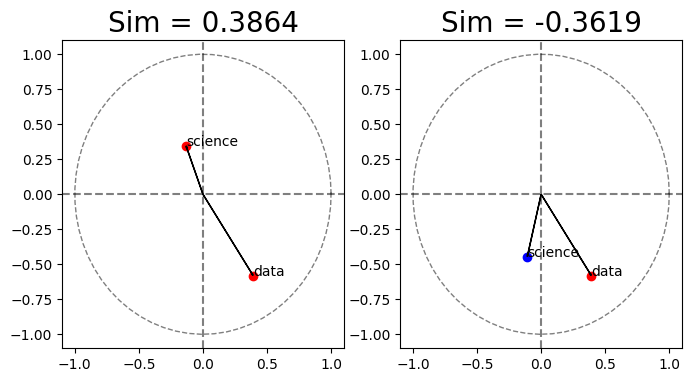

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

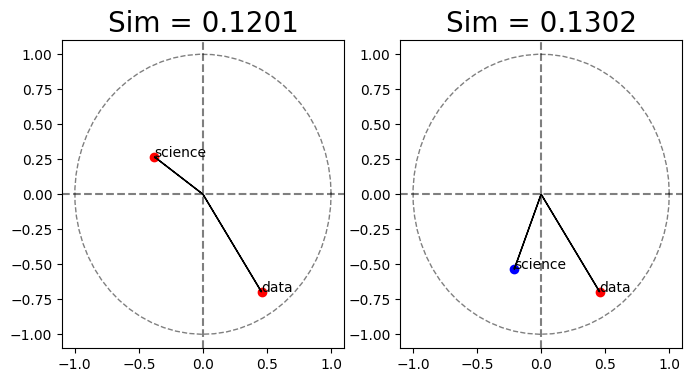

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

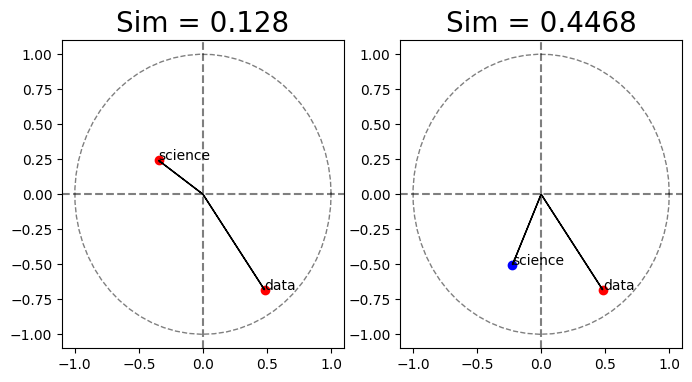

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

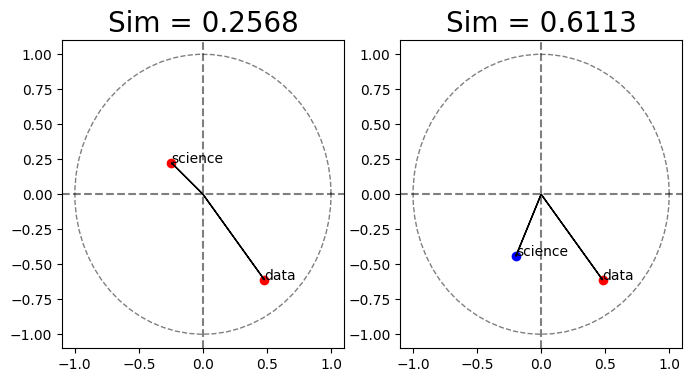

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

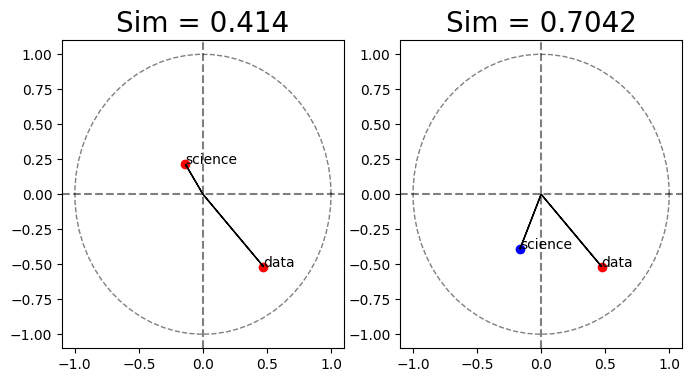

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

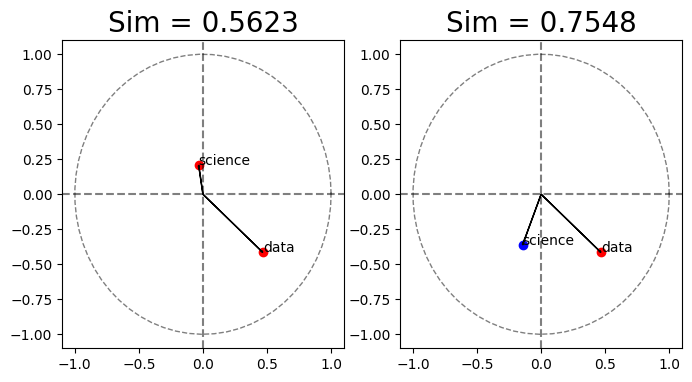

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

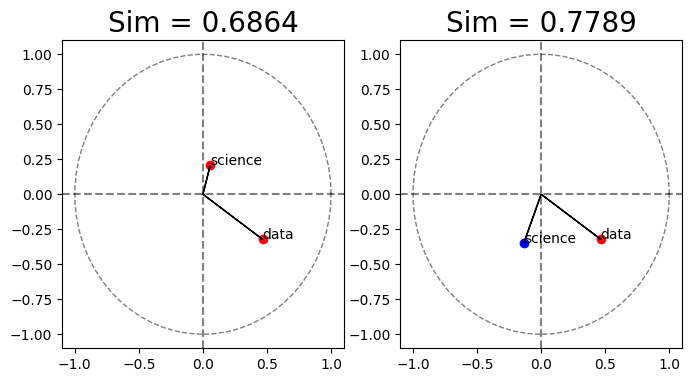

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

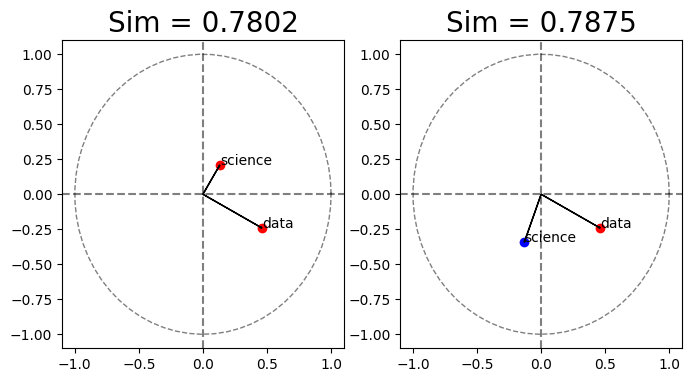

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

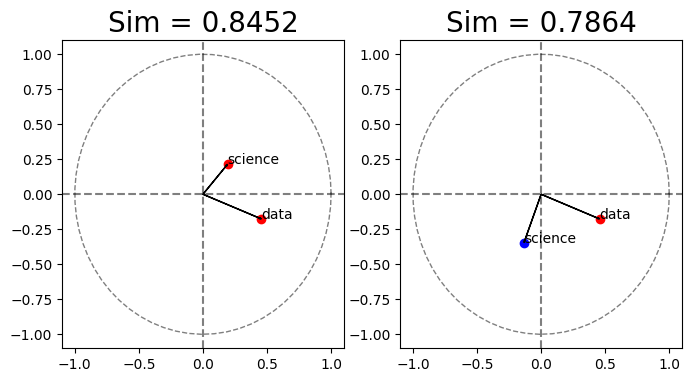

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

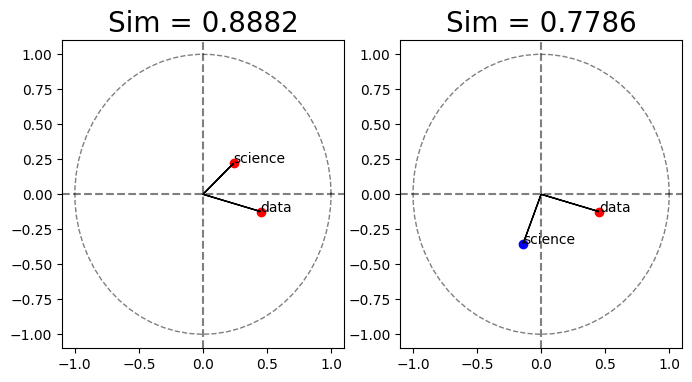

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

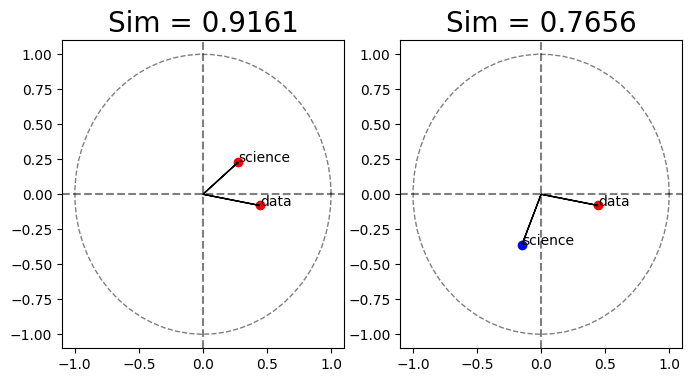

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

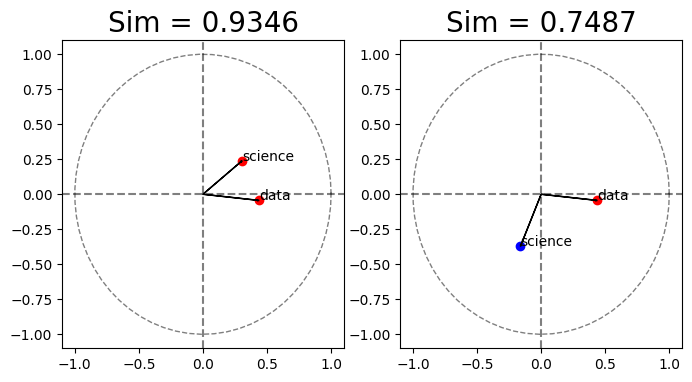

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

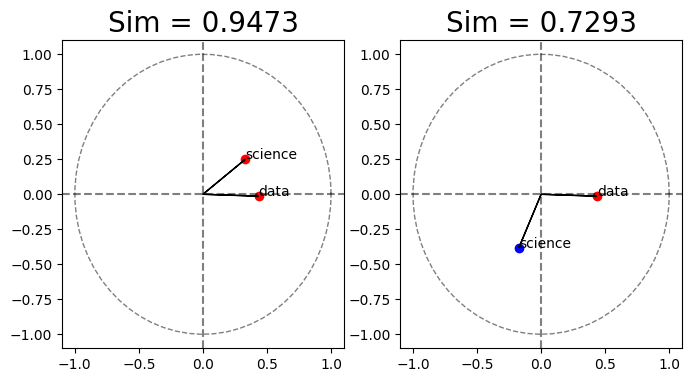

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

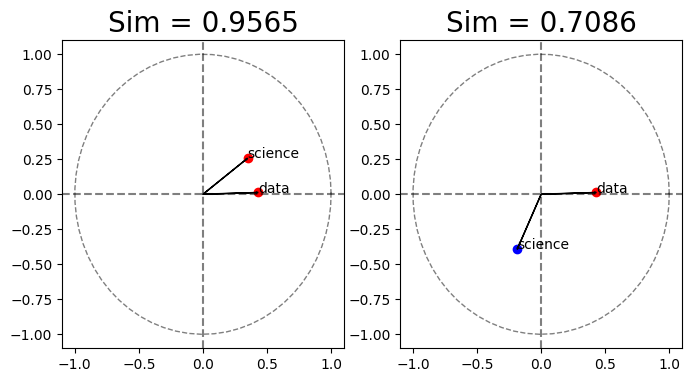

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

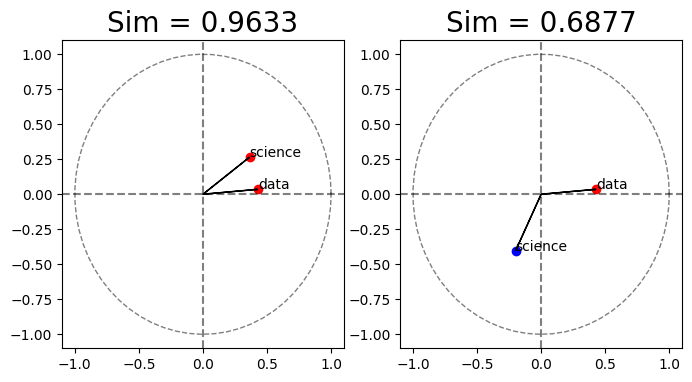

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

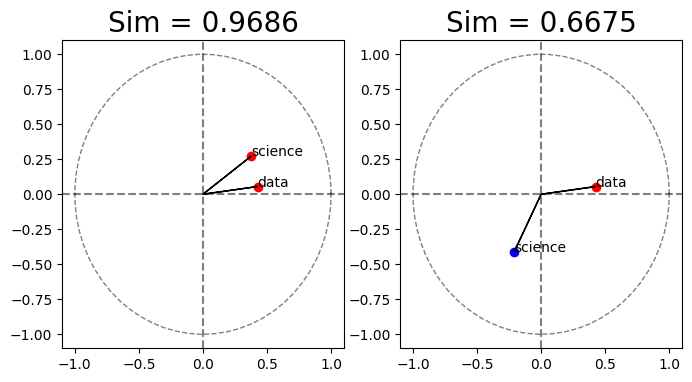

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

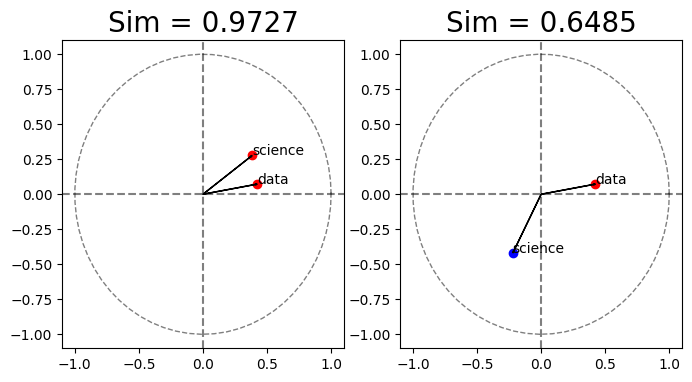

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

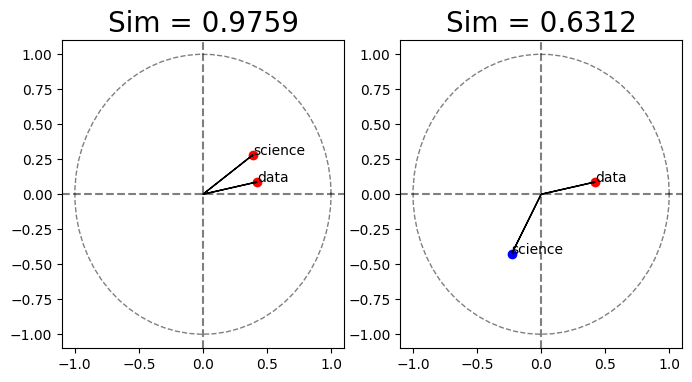

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

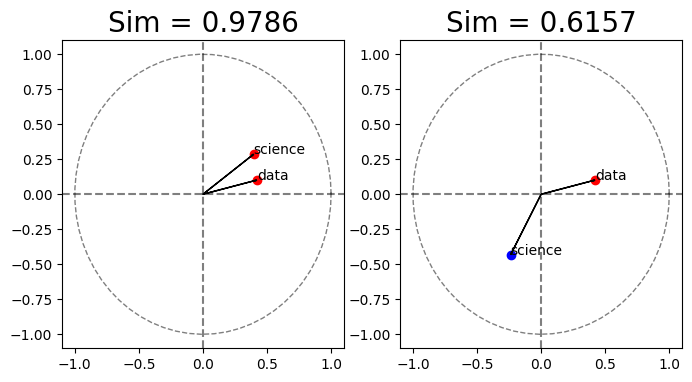

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

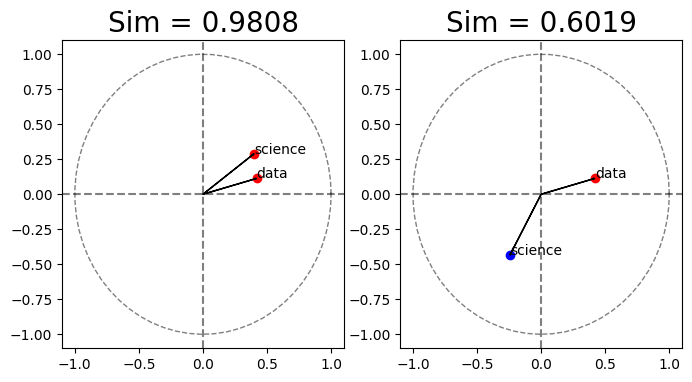

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

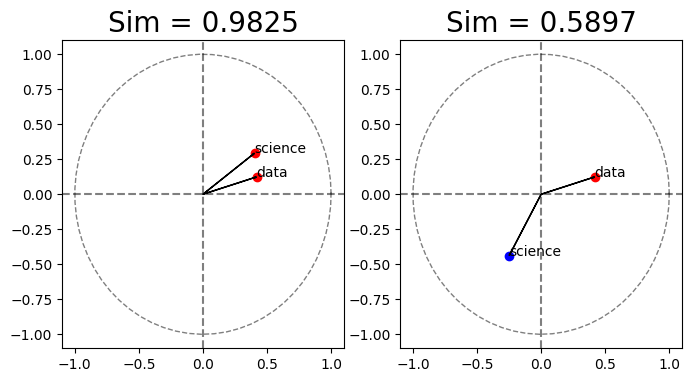

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

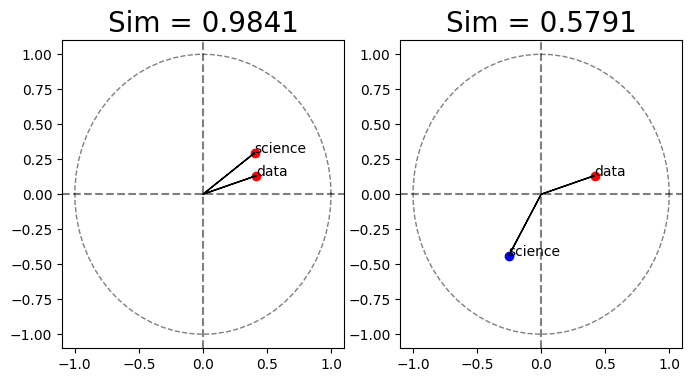

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

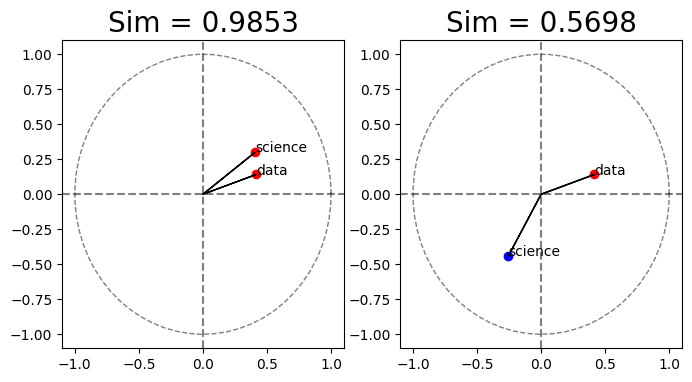

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

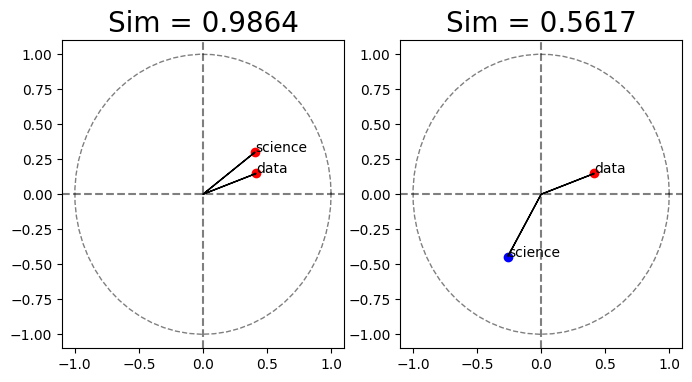

/tmp/ipython-input-2894930596.py:8: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_first[0]), float(lim_main_first[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main_second[0]), float(lim_main_second[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:29: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  plt.arrow(0,0,float(lim_main[0]), float(lim_main[1]), head_width=0.01, length_includes_head=True)
/tmp/ipython-input-2894930596.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError i

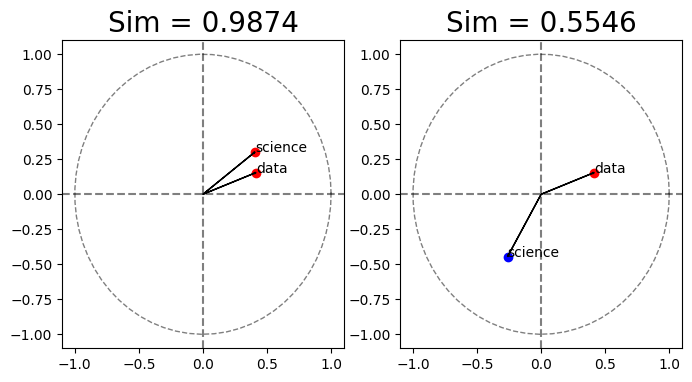

In [14]:
# EMBEDDING_SIZE: the number of axises (dimensions)
# because of too many topics, only 2 axes cannot hold the closeness correctly
EMBEDDING_SIZE = 5

# generate a random matrix with shape (len(words) as row num, EMBEDDING_SIZE as col num)
# w/ mean = 0, deviation = 0.1 => generate numbers centered around 0, roughly close by +-0.1 (very near 0)
main_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
# find the length of the vector by Pythegon theory => reshape them into 1 col
row_norms = np.sqrt((main_embeddings**2).sum(axis=1)).reshape(-1,1)
# / to make the length = 1
# make the length = 1 to avoid dot prod of any word to be too large and make it seem too far from the similar words
main_embeddings = main_embeddings / row_norms


context_embeddings = np.random.normal(0,0.1,(len(words), EMBEDDING_SIZE))
row_norms = np.sqrt((context_embeddings**2).sum(axis=1)).reshape(-1,1)
context_embeddings = context_embeddings / row_norms

main_embeddings = pd.DataFrame(data=main_embeddings, index=words)
context_embeddings = pd.DataFrame(data=context_embeddings, index=words)

for _ in range(25):
    main_embeddings, context_embeddings = update_embeddings(df, main_embeddings, context_embeddings, 0.1, ['data', 'science'])

In [15]:
similarities = []
for w1 in words:
    for w2 in words:
        if w1 != w2:
          # compute the similarities
            sim = 1 - cosine(main_embeddings.loc[w1], main_embeddings.loc[w2])
            similarities.append((w1,w2,sim))
# only take the item[0](w1) = 'data' =>  key=lambda t: -t[2]: in a descending order => only take ten first words
sorted([item for item in similarities if item[0] == 'data'], key=lambda t: -t[2])[:10]

[(np.str_('data'), np.str_('science'), np.float64(0.988204458081489)),
 (np.str_('data'), 'statistics', np.float64(0.9824302070155733)),
 (np.str_('data'), 'studying', np.float64(0.9661611460695002)),
 (np.str_('data'), np.str_('became'), np.float64(0.8849535316088528)),
 (np.str_('data'), 'long', np.float64(0.8292403680442318)),
 (np.str_('data'), np.str_('fundamentals'), np.float64(0.7675530264633224)),
 (np.str_('data'), 'hot', np.float64(0.5974824131569715)),
 (np.str_('data'), 'talk', np.float64(0.5504354469445895)),
 (np.str_('data'), 'listening', np.float64(0.502238581627354)),
 (np.str_('data'), 'thanks', np.float64(0.4947838217315279))]